# Explainable COVID-19 Chest X-Ray Classification using VGG16 and Grad-CAM

### 1. Project Overview

This project presents a multi-class classification system for chest X-ray images to distinguish between:

- COVID-19
- Viral Pneumonia
- Normal

The objective is to build a reliable deep learning model using transfer learning and to validate not only its predictive performance but also its interpretability.

---

### 2. Motivation

Medical image classification requires more than high accuracy. In healthcare applications, model reliability, transparency, and interpretability are critical.

To address this, the project integrates:

- Transfer Learning (VGG16 pretrained on ImageNet)
- Class imbalance handling
- Learning curve analysis
- Confusion matrix evaluation
- Grad-CAM visualization for explainability

---

### 3. Dataset Description

The dataset consists of labeled chest X-ray images divided into three classes:

- Normal
- Viral Pneumonia
- COVID-19

Due to the relatively small dataset size, careful regularization and validation strategies were applied to reduce overfitting and improve generalization.

---

### 4. Methodology

The workflow includes:

1. Data preprocessing and augmentation  
2. Transfer learning using pretrained VGG16  
3. Fine-tuning the classifier head  
4. Model evaluation using accuracy, loss curves, and confusion matrix  
5. Interpretability analysis using Grad-CAM  

---

### 5. Key Objective

Beyond achieving strong validation performance, the primary goal of this project is to verify that the model focuses on clinically relevant lung regions rather than image artifacts or dataset biases.

This ensures that the model's predictions are not only accurate but also explainable.

---

### 6. Disclaimer

This project is intended for educational and research purposes only.  
The dataset size is limited, and the model is not suitable for real-world clinical deployment without extensive external validation.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## 📂 **Data Preparation & Distribution** 📊

In [2]:
train_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
test_dir  = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset  = ImageFolder(root=test_dir, transform=transform)

from collections import Counter

# Count train samples per class
train_labels = [label for _, label in train_dataset.samples]
train_counts = Counter(train_labels)

print("Train Data Counts:")
for class_name, idx in train_dataset.class_to_idx.items():
    print(f"{class_name}: {train_counts[idx]}")

# Count test samples per class
test_labels = [label for _, label in test_dataset.samples]
test_counts = Counter(test_labels)

print("\nTest Data Counts:")
for class_name, idx in test_dataset.class_to_idx.items():
    print(f"{class_name}: {test_counts[idx]}")

Train Data Counts:
Covid: 111
Normal: 70
Viral Pneumonia: 70

Test Data Counts:
Covid: 26
Normal: 20
Viral Pneumonia: 20


load the datasets using `ImageFolder` and analyze the **Class Balance** across the **Train** and **Test** sets.

### 🧪 **Quick Summary**
* **Covid:** 111 Train | 26 Test 🦠
* **Normal:** 70 Train | 20 Test ✅
* **Viral Pneumonia:** 70 Train | 20 Test 🫁

> **Result:** A total of **251** training and **66** testing images are ready for the model! 🚀

In [5]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

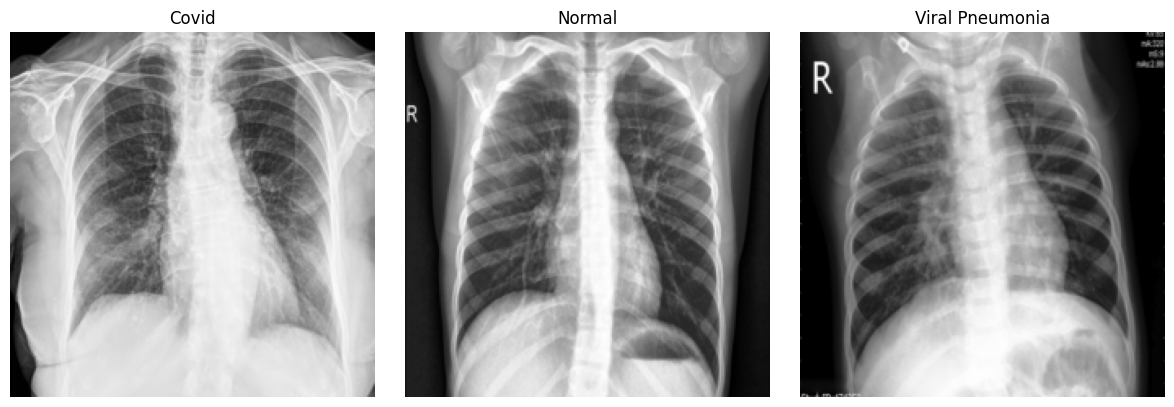

In [6]:
samples = {}

for img, label in train_loader:
    class_name = train_dataset.classes[label.item()]
    if class_name not in samples:
        samples[class_name] = img
    if len(samples) == len(train_dataset.classes):
        break

# Plot
plt.figure(figsize=(12, 4))

for i, (class_name, img) in enumerate(samples.items()):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

##  **Image Preprocessing** ⚙️

We apply **Transformations** to ensure the data is compatible with the **VGG Model** architecture.

### 🛠️ **Preprocessing Steps**
* **Resizing:** Scaling all images to **224x224** (VGG Input Size). 📏
* **Grayscale to RGB:** Converting to 3-channel grayscale to match **VGG's** expected input. 🔳
* **Augmentation:** Applying **Random Flips** and **Rotations** to prevent overfitting. 🔄
* **Normalization:** Scaling using **ImageNet** standards ($mean=[0.485, 0.456, 0.406]$). ⚖️

> **Note:** These steps ensure our images are perfectly formatted for a **VGG-based** transfer learning approach! 🚀

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset  = ImageFolder(test_dir, transform=test_transform)

## 📦 **Data Loading & Batching Strategy** ⚙️

We initialize the `DataLoaders` with a **Batch Size of 16** to enhance **generalization** and provide smoother gradient updates.

### 🛠️ **Loading Configuration**
* **Batch Size:** Set to **16** (Testing for optimal convergence; **32** will be evaluated later). 🔢
* **Shuffling:** Enabled for **Train Set** to reduce model bias. 🔄
* **Parallel Processing:** Using `num_workers=2` for efficient data fetching. ⚡

> **Strategy:** Starting with a smaller batch size (16) to improve the model's ability to **generalize** on unseen data before scaling up to 32. 🚀

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

## 🧠 **VGG16 Model:** Initializing **Pre-trained Weights**

In [9]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 221MB/s]


### 🔒 **Freezing VGG16 Features** 🧱

We **freeze** all parameters in `model.features` to prevent **Overfitting** and ensure efficient **Transfer Learning**.

### 💡 **Why Freeze?**
* **Parameter Scale:** VGG16 has **~138 million** parameters. 🏗️
* **Dataset Size:** With only **251 images**, training the full network would be a **disaster**. 📉
* **Strategy:** Keeping the pre-trained **ImageNet** features while only tuning the final layers. ✅

> **Result:** Model training is now **faster** and more stable for our small dataset! 🚀

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

### 🎯 **Output Layer:** Replaced the final classifier with a **3-class Linear Layer**

In [11]:
model.classifier[6] = nn.Linear(4096, 3)
model = model.to(device)

### ⚖️ **Weighted Cross-Entropy Loss** 📉

We compute **Inverse Frequency Weights** ($N / (C \times n_i)$) to balance our dataset and prevent model bias toward the majority class. 

> **Impact:** These weights are integrated into `CrossEntropyLoss`, ensuring the model penalizes errors on **minority classes** more heavily for fairer predictions. 🚀

In [12]:
labels = [label for _, label in train_dataset.samples]

counts = Counter(labels)

print("Class counts:", counts)

Class counts: Counter({0: 111, 1: 70, 2: 70})


In [13]:
num_classes = len(train_dataset.classes)
total_samples = len(train_dataset)

class_weights = []

for i in range(num_classes):
    class_count = counts[i]
    weight = total_samples / (num_classes * class_count)
    class_weights.append(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)

Class weights: tensor([0.7538, 1.1952, 1.1952])


### Loss + Optimizer

In [14]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = torch.optim.Adam(
    model.classifier.parameters(),  # only train classifier
    lr=1e-4
)

In [15]:
from sklearn.metrics import accuracy_score
import torch

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)

    # Store train metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    # Store val metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"- loss: {train_loss:.4f} "
          f"- acc: {train_acc:.4f} "
          f"- val_loss: {val_loss:.4f} "
          f"- val_acc: {val_acc:.4f}")

Epoch [1/10] - loss: 0.7501 - acc: 0.7171 - val_loss: 0.5524 - val_acc: 0.7727
Epoch [2/10] - loss: 0.2512 - acc: 0.8964 - val_loss: 0.2328 - val_acc: 0.9394
Epoch [3/10] - loss: 0.1558 - acc: 0.9363 - val_loss: 0.1320 - val_acc: 0.9848
Epoch [4/10] - loss: 0.1027 - acc: 0.9681 - val_loss: 0.1199 - val_acc: 0.9545
Epoch [5/10] - loss: 0.0575 - acc: 0.9841 - val_loss: 0.0484 - val_acc: 0.9848
Epoch [6/10] - loss: 0.0621 - acc: 0.9761 - val_loss: 0.0527 - val_acc: 1.0000
Epoch [7/10] - loss: 0.0464 - acc: 0.9841 - val_loss: 0.0454 - val_acc: 0.9848
Epoch [8/10] - loss: 0.0740 - acc: 0.9761 - val_loss: 0.0709 - val_acc: 0.9697
Epoch [9/10] - loss: 0.0685 - acc: 0.9880 - val_loss: 0.0941 - val_acc: 0.9545
Epoch [10/10] - loss: 0.0507 - acc: 0.9880 - val_loss: 0.0129 - val_acc: 1.0000


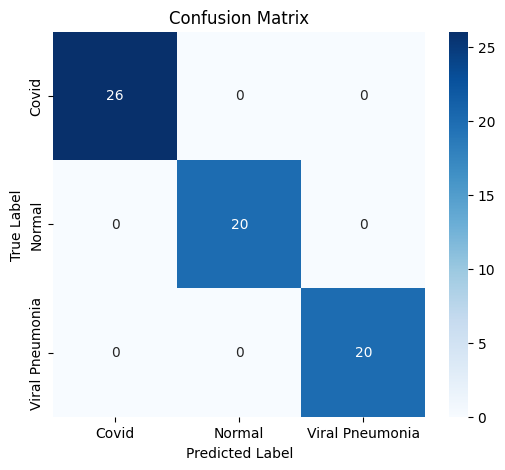

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_labels, val_preds)

# Class names
class_names = train_dataset.classes

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

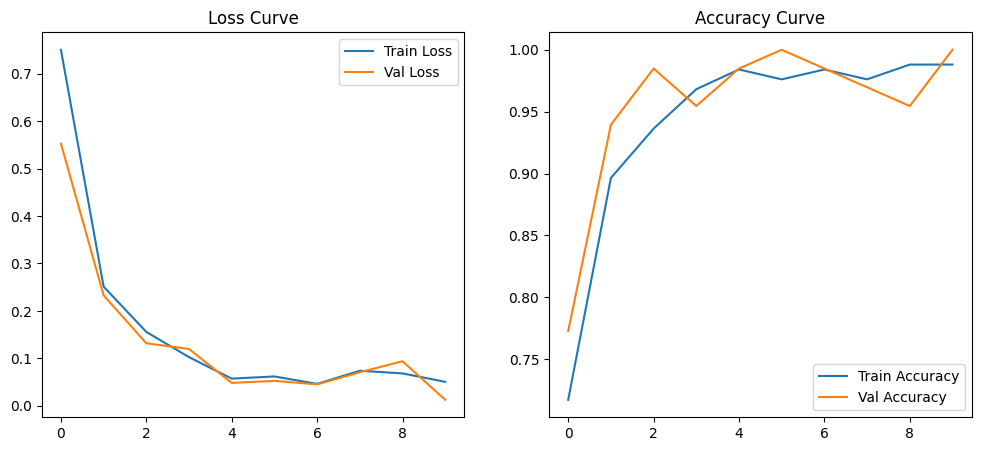

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [18]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=e10786617281db8dfa63aae4804621742a6cc465630439131e950a0f6408c14c
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [20]:
target_layer = model.features[-1]

model.eval()

# Get one batch
images, labels = next(iter(test_loader))

image = images[0].to(device)
label = labels[0].item()

input_tensor = image.unsqueeze(0)

### Enable Gradients For Feature Layers (Temporarily)

In [21]:
for param in model.features.parameters():
    param.requires_grad = True

In [22]:
import numpy as np

def generate_gradcam(image_tensor, model, target_layer):
    model.eval()

    cam = GradCAM(model=model, target_layers=[target_layer])

    input_tensor = image_tensor.unsqueeze(0).to(device)

    outputs = model(input_tensor)
    _, pred_class = torch.max(outputs, 1)

    targets = [ClassifierOutputTarget(pred_class.item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # De-normalize image
    img = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    visualization = show_cam_on_image(
        img.astype(np.float32),
        grayscale_cam,
        use_rgb=True
    )

    return visualization, pred_class.item()

In [23]:
class_images = {}
class_names = train_dataset.classes

for images, labels in test_loader:
    for i in range(len(labels)):
        label_name = class_names[labels[i].item()]
        
        if label_name not in class_images:
            class_images[label_name] = images[i]
        
        if len(class_images) == 3:
            break
    
    if len(class_images) == 3:
        break

In [24]:
visualizations = {}

for class_name, image_tensor in class_images.items():
    vis, pred = generate_gradcam(image_tensor, model, target_layer)
    visualizations[class_name] = vis

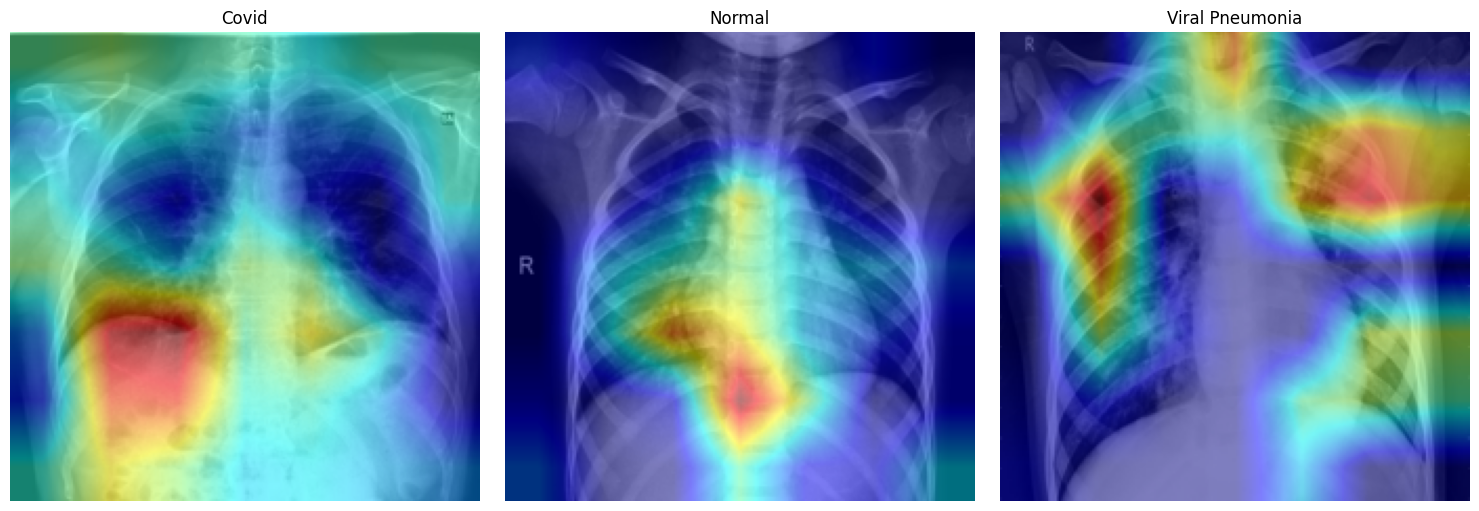

In [25]:
plt.figure(figsize=(15,5))

for i, (class_name, vis) in enumerate(visualizations.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow(vis)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()